<a href="https://colab.research.google.com/github/waqarmm/AI-Labs/blob/master/WaqarCapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cd '/content/drive'

In [ ]:
!git clone https://github.com/NisargC/BrainTumourDetection.git

Cloning into 'BrainTumourDetection'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 239 (delta 3), reused 235 (delta 2), pack-reused 0
Receiving objects: 100% (239/239), 5.16 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (257/257), done.


In [6]:
files = glob.glob('/content/drive/MyDrive/finalcapstoneDS/ds/BrainTumourDetection/dataset/yes/*.jpg') + glob.glob('/content/drive/MyDrive/finalcapstoneDS/ds/BrainTumourDetection/dataset/yes/*.jpeg')+ glob.glob('/content/drive/MyDrive/finalcapstoneDS/ds/BrainTumourDetection/dataset/yes/*.JPG')
files_no = glob.glob('/content/drive/MyDrive/finalcapstoneDS/ds/BrainTumourDetection/dataset/no/*.jpg') + glob.glob('/content/drive/MyDrive/finalcapstoneDS/ds/BrainTumourDetection/dataset/no/*.jpeg')+ glob.glob('/content/drive/MyDrive/finalcapstoneDS/ds/BrainTumourDetection/dataset/yes/*.JPG')


Image Count: 314
Post Augmentation Count: 2628
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14764866 (56.32 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
83/83 [==============================] - 17s 192ms/step - loss: 32.2065 - accuracy

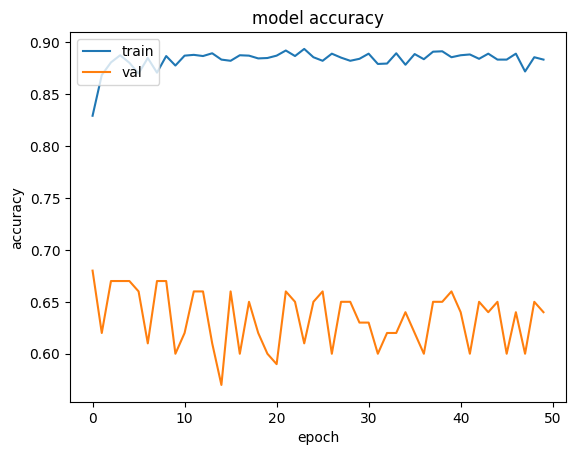

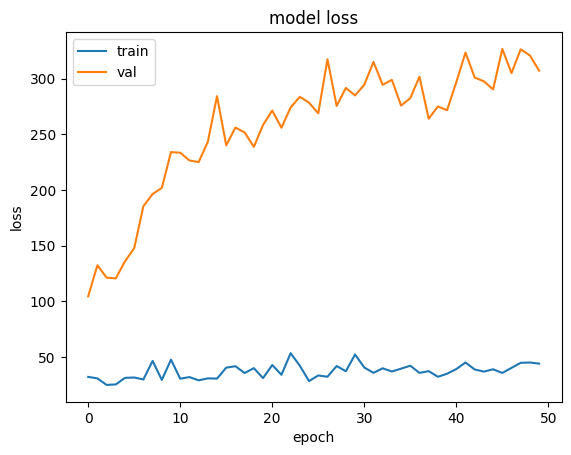

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14764866 (56.32 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 5s 5s/step
Predicted classes
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Actual classes
[1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Len of testset: 26
46.15384615384615


In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import glob
import platform

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import imutils
from keras import optimizers, Input
from keras.applications import VGG16, resnet, VGG19, InceptionResNetV2
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_resnet_v2 import preprocess_input
from skimage import feature
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing, metrics
from sklearn import svm
from keras.models import load_model

"""
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes
    (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3)
    to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to X and its label to y.
6. Split the dataset
7. Build model
8. Train
9. Optimize
10. Predict
11. Plot
"""


def read_train_set():
    # preprocess_images()
    annotations = {}
    X_flattened, X_images, Y = [], [], []
    i = 1
    for file in files_no:
        annotations[file.split('/')[-1].split('\\')[-1]] = '0'
        i += 1
        img = cv2.imread(file)

        img = cv2.resize(img, (240, 240))
        img = hist_eq_3D(img)
        X_flattened.append(img.flatten().flatten())
        X_images.append(img)

        separator = '/'
        if platform.system() == 'Windows':
            separator = '\\'
        Y.append(annotations[str(file).split(separator)[-1]])

    for file in files:
        annotations[file.split('/')[-1].split('\\')[-1]] = '1'
        i += 1
        img = cv2.imread(file)

        img = cv2.resize(img, (240, 240))
        img = hist_eq_3D(img)
        X_flattened.append(img.flatten().flatten())
        X_images.append(img)

        separator = '/'
        if platform.system() == 'Windows':
            separator = '\\'
        Y.append(annotations[str(file).split(separator)[-1]])

    print("Image Count: "+ str(i))
    return np.array(X_flattened), np.array(X_images), np.array(Y)


def data_augmentation(folder_name, times):
    train_data_generator = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=preprocess_input
    )
    for filename in os.listdir('dataset/' + folder_name):
        image = cv2.imread('dataset/' + folder_name + '/' + filename)
        image = image.reshape((1,) + image.shape)
        # Don't re-augment augmented data
        if 'aug' in filename:
            continue
        i = 0

        for batch in train_data_generator.flow(x=image, batch_size=32,
                                               save_to_dir='dataset/' + folder_name,
                                               save_prefix='aug_' + filename[:-4], save_format='jpg'):
            i += 1
            if i > times:
                break


def data_aug_arrays(X, Y, yes_count, no_count):
    for i, v in enumerate(X):
        v = np.reshape(v, (1, 240, 240, 3))
        k = np.reshape(Y[i], (1,))
        count = 0
        j = 0
        if Y[i] == '0':
            count = no_count
        else:
            count = yes_count
        for j in range(count):
            X = np.concatenate((X, v))
            Y = np.concatenate((Y, k))
    print("Post Augmentation Count: " + str(Y.shape[0] + 1))
    return X, Y


# def augmentation_cleanup():
#     # Remove from annotations
#     for folder in os.listdir('dataset/'):
#         if folder == 'annotations.csv':
#             continue
#         for filename in os.listdir('dataset/' + folder):
#             if 'aug' in filename:
#                 os.remove('dataset/' + folder + "/" + filename)


def preprocess_images():
    for file in os.listdir('dataset/no'):
        rec_img = cv2.imread('dataset/no/' + file)
        # plt.imshow(rec_new_img)
        rec_new_img = crop_brain_contour(rec_img)
        # plt.imshow(rec_new_img)
        # zero_padded_img = ZeroPadding2D((2, 2))(rec_new_img) # shape=(?, 244, 244, 3)
        plt.imsave('dataset/no/' + file, rec_new_img)

    for file in os.listdir('dataset/yes'):
        rec_img = cv2.imread('dataset/yes/' + file)
        # plt.imshow(rec_new_img)
        rec_new_img = crop_brain_contour(rec_img)
        # plt.imshow(rec_new_img)
        plt.imsave('dataset/yes/' + file, rec_new_img)


# Function top crop brain contour
def crop_brain_contour(image):
    image_width = 240
    image_height = 240

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    resized_image = cv2.resize(new_image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    normalized_image = resized_image / 255.

    return normalized_image


def hist_eq_2D(channel):
    return cv2.equalizeHist(channel)


def hist_eq_3D(img):
    b, g, r = cv2.split(img)
    b = hist_eq_2D(b)
    g = hist_eq_2D(g)
    r = hist_eq_2D(r)
    img = cv2.merge((b, g, r))
    return img


def calc_accuracy(Y, Y_pred):
    total = len(Y)
    print("Len of testset: " + str(total))
    correct = sum([int(Y_pred[i] == Y[i]) for i in range(total)])
    return correct * 100 / total


def pca_transform(x):
    pca = PCA(n_components=150, svd_solver='full', whiten=True)
    transformed_x = pca.fit_transform(x)
    # transformed_x_val = pca.transform(x_val)
    return transformed_x


def one_hot_fit(Y):
    labels = preprocessing.LabelEncoder()
    labels.fit(Y)
    return labels


def one_hot_transform(labels, Y):
    encoded_labels = labels.transform(Y)
    one_hot_y = to_categorical(encoded_labels)
    return one_hot_y


def hog_transform(X):
    X_hog = []
    for x in X:
        fd_hog = feature.hog(x,
                             # orientations=16,
                             # pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                             multichannel=True)
        X_hog.append(fd_hog)

    return np.array(X_hog)


def baseline_model(input_shape):
    # MLP model to establish baseline
    np.random.seed(7)
    model = Sequential()
    model.add(Dense(int(input_shape[0]), input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(input_shape[0] / 2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(input_shape[0] / 4), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def model_cnn(input_shape):
    # Initialising the CNN
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(input_shape[1], input_shape[2], input_shape[3]),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=2, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                  )
    model.summary()
    return model


def transfer_learning(input_shape):
    new_input = Input(shape=(input_shape[1], input_shape[2], input_shape[3]))
    # base_model = resnet.ResNet50(include_top=False, input_tensor=new_input, weights='imagenet')
    base_model = VGG16(include_top=False, input_tensor=new_input, weights='imagenet')
    # base_model = VGG19(include_top=False, input_tensor=new_input)
    model = Sequential()
    model.add(base_model)
    for layer in base_model.layers[:-2]:
        layer.trainable = False
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='sigmoid'))
    model.layers[0].trainable = False
    adam = optimizers.Adam(learning_rate=0.01)
    model.compile(
        loss='binary_crossentropy',
        optimizer=adam,
        metrics=['accuracy']
    )
    model.summary()
    return model


def svmModel(X, Y):
    # 'linear', 'poly', 'rbf', 'sigmoid'
    clf = svm.SVC(gamma='auto', kernel='linear')
    print("In svm before fit")
    clf.fit(X, Y)
    print("In svm fitting done")
    return clf


# MAIN::

# preprocess_images()
# augmentation_cleanup()
# data_augmentation('yes', 9)
# data_augmentation('no', 14)
x, x_images, y = read_train_set()
# augmentation_cleanup()

# # # X_train, X_test, X_val = pca_transform(X_train, X_test, X_val)
# x_images = hog_transform(x_images)
# print("HOG transform done")
X_train, X_val, Y_train, Y_val = train_test_split(x_images, y, test_size=0.4, stratify=y,
                                                  random_state=np.random.randint(6, size=1)[0])
X_train, Y_train = data_aug_arrays(X_train, Y_train, 10, 16)

X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.2, stratify=Y_val,
                                                random_state=np.random.randint(10, size=1)[0])

# # # classifier = create_baseline(X_train[0].shape)
# clf = svmModel(X_train, Y_train)
# print("Classification report for - \n{}\n".format(metrics.classification_report(Y_test, y_pred)))

# classifier = load_model('model_transfer_learning1e4_unfreeze1_backup.h5')
classifier = transfer_learning(X_train.shape)
#classifier = model_cnn(X_train.shape)
one_hot = one_hot_fit(Y_train)
Y_train = one_hot_transform(one_hot, Y_train)
Y_val = one_hot_transform(one_hot, Y_val)
train_val_data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_val_data_generator.flow(X_train, Y_train, batch_size=32)
val_generator = train_val_data_generator.flow(X_val, Y_val, batch_size=32)
test_generator = test_data_generator.flow(X_test, Y_test, batch_size=32)

es = EarlyStopping(
    monitor='val_loss',
    mode='max',
    restore_best_weights=True,
    patience=3
)
# history = classifier.fit_generator(train_generator,
#                                    verbose=1,
#                                    epochs=50,
#                                    validation_data=val_generator,
#                                    steps_per_epoch=len(X_train) / 32,
#                                    shuffle=True,
#                                    validation_steps=len(X_val) / 32,
#                                    callbacks=[es]
                                    #  )

history = classifier.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, validation_data=(X_val, Y_val))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

classifier.save("./transferlearnn.h5")
classifier.summary()
prediction = classifier.predict(test_generator)
y_prediction = list(np.argmax(prediction, axis=1))
print("Predicted classes")
print(y_prediction)
test_list = list(map(int, Y_test))
print("Actual classes")
print(test_list)
print(calc_accuracy(test_list, y_prediction))

In [ ]:
##GPT CODE 11NOV
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import glob
import platform

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import imutils
from keras import optimizers, Input
from keras.applications import VGG16, resnet, VGG19, InceptionResNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_resnet_v2 import preprocess_input
from skimage import feature
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing, metrics
from sklearn import svm

"""
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes
    (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3)
    to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to X and its label to y.
6. Split the dataset
7. Build model
8. Train
9. Optimize
10. Predict
11. Plot
"""


def read_train_set():
    # preprocess_images()
    annotations = {}
    X_flattened, X_images, Y = [], [], []
    i = 1
    for file in files_no:
        annotations[file.split('/')[-1].split('\\')[-1]] = '0'
        i += 1
        img = cv2.imread(file)

        img = cv2.resize(img, (240, 240))
        img = hist_eq_3D(img)
        X_flattened.append(img.flatten().flatten())
        X_images.append(img)

        separator = '/'
        if platform.system() == 'Windows':
            separator = '\\'
        Y.append(annotations[str(file).split(separator)[-1]])

    for file in files:
        annotations[file.split('/')[-1].split('\\')[-1]] = '1'
        i += 1
        img = cv2.imread(file)

        img = cv2.resize(img, (240, 240))
        img = hist_eq_3D(img)
        X_flattened.append(img.flatten().flatten())
        X_images.append(img)

        separator = '/'
        if platform.system() == 'Windows':
            separator = '\\'
        Y.append(annotations[str(file).split(separator)[-1]])

    print("Image Count: " + str(i))
    return np.array(X_flattened), np.array(X_images), np.array(Y)


def data_augmentation(folder_name, times):
    train_data_generator = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True,
        vertical_flip=True,
        preprocessing_function=preprocess_input
    )
    for filename in os.listdir('dataset/' + folder_name):
        image = cv2.imread('dataset/' + folder_name + '/' + filename)
        image = image.reshape((1,) + image.shape)
        # Don't re-augment augmented data
        if 'aug' in filename:
            continue
        i = 0

        for batch in train_data_generator.flow(x=image, batch_size=32,
                                               save_to_dir='dataset/' + folder_name,
                                               save_prefix='aug_' + filename[:-4], save_format='jpg'):
            i += 1
            if i > times:
                break


def data_aug_arrays(X, Y, yes_count, no_count):
    for i, v in enumerate(X):
        v = np.reshape(v, (1, 240, 240, 3))
        k = np.reshape(Y[i], (1,))
        count = 0
        j = 0
        if Y[i] == '0':
            count = no_count
        else:
            count = yes_count
        for j in range(count):
            X = np.concatenate((X, v))
            Y = np.concatenate((Y, k))
    print("Post Augmentation Count: " + str(Y.shape[0] + 1))
    return X, Y


def crop_brain_contour(image):
    image_width = 240
    image_height = 240

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    resized_image = cv2.resize(new_image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    normalized_image = resized_image / 255.

    return normalized_image


def hist_eq_2D(channel):
    return cv2.equalizeHist(channel)


def hist_eq_3D(img):
    b, g, r = cv2.split(img)
    b = hist_eq_2D(b)
    g = hist_eq_2D(g)
    r = hist_eq_2D(r)
    img = cv2.merge((b, g, r))
    return img


def calc_accuracy(Y, Y_pred):
    total = len(Y)
    print("Len of testset: " + str(total))
    correct = sum([int(Y_pred[i] == Y[i]) for i in range(total)])
    return correct * 100 / total


def pca_transform(x):
    pca = PCA(n_components=150, svd_solver='full', whiten=True)
    transformed_x = pca.fit_transform(x)
    return transformed_x


def one_hot_fit(Y):
    labels = preprocessing.LabelEncoder()
    labels.fit(Y)
    return labels


def one_hot_transform(labels, Y):
    encoded_labels = labels.transform(Y)
    one_hot_y = to_categorical(encoded_labels)
    return one_hot_y


def hog_transform(X):
    X_hog = []
    for x in X:
        fd_hog = feature.hog(x,
                             # orientations=16,
                             # pixels_per_cell=(16, 16), cells_per_block=(1, 1),
                             multichannel=True)
        X_hog.append(fd_hog)

    return np.array(X_hog)


def baseline_model(input_shape):
    np.random.seed(7)
    model = Sequential()
    model.add(Dense(int(input_shape[0]), input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(input_shape[0] / 2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(int(input_shape[0] / 4), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def model_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(input_shape[1], input_shape[2], input_shape[3]),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(units=64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(units=2, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


# ... (previous code)

def transfer_learning(input_shape):
    new_input = Input(shape=(input_shape[1], input_shape[2], input_shape[3]))
    base_model = VGG16(include_top=False, input_tensor=new_input, weights='imagenet')
    model = Sequential()
    model.add(base_model)

    # Make more layers trainable
    for layer in base_model.layers[:-10]:
        layer.trainable = True

    model.add(Flatten())
    model.add(BatchNormalization())  # Batch normalization
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Reduce number of neurons
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    model.summary()
    return model
# ... (remaining code)



def svmModel(X, Y):
    clf = svm.SVC(gamma='auto', kernel='linear')
    clf.fit(X, Y)
    return clf


# MAIN::

x, x_images, y = read_train_set()

#x_images = hog_transform(x_images)
print("HOG transform done")

X_train, X_val, Y_train, Y_val = train_test_split(x_images, y, test_size=0.4, stratify=y,
                                                  random_state=np.random.randint(6, size=1)[0])
X_train, Y_train = data_aug_arrays(X_train, Y_train, 10, 16)

X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.2, stratify=Y_val,
                                                random_state=np.random.randint(10, size=1)[0])

classifier = transfer_learning(X_train.shape)
one_hot = one_hot_fit(Y_train)
Y_train = one_hot_transform(one_hot, Y_train)
Y_val = one_hot_transform(one_hot, Y_val)

train_val_data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_val_data_generator.flow(X_train, Y_train, batch_size=32)
val_generator = train_val_data_generator.flow(X_val, Y_val, batch_size=32)
test_generator = test_data_generator.flow(X_test, Y_test, batch_size=32)

es = EarlyStopping(
    monitor='val_loss',
    mode='max',
    restore_best_weights=True,
    patience=10
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = classifier.fit(
    train_generator,
    verbose=1,
    epochs=50,
    validation_data=val_generator,
    steps_per_epoch=len(X_train) / 32,
    shuffle=True,
    validation_steps=len(X_val) / 32,
    callbacks=[es, reduce_lr]
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

classifier.save("./transferlearnn.h5")
classifier.summary()

prediction = classifier.predict(test_generator)
y_prediction = list(np.argmax(prediction, axis=1))
print("Predicted classes")
print(y_prediction)
test_list = list(map(int, Y_test))
print("Actual classes")
print(test_list)
print(calc_accuracy(test_list, y_prediction))


Image Count: 314
HOG transform done
Post Augmentation Count: 2628
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense_6 (Dense)             (None, 64)                1605696   
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [ ]:
cd BrainTumourDetection/

/content/drive/MyDrive/finalcapstoneDS/ds/BrainTumourDetection


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!chmod 777 '/content/drive/MyDrive/finalcapstoneDS/ds/'